# Optimizing patterns
In this tutorial, we will explain how to use Dr.TVAM to optimize patterns for printing.

<div class="admonition important alert alert-block alert-success">

🚀 **We will cover the following topics:**
    
<ul>
  <li>How to setup the optimization</li>
  <li>Implementing a basic optimization loop </li>
  <li>Extracting and saving the results </li>
</ul>
    
</div>


We start once again by importing `drtvam`  along with other packages:

In [1]:
import drtvam
import mitsuba as mi
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

## 1. Setting up the scene

Setting up Dr.TVAM for optimization is quite similar than what we showed in the previous tutorial, with a few exceptions. We will start again by describing the scene components. For clarity, we will reuse the same printing setup we described in the previous tutorial.


In [2]:
scene_dict = {'type': 'scene'}

### Container geometry

Container geometry is described as before:

In [3]:
vial_params = {
    'r_int': 5., # 10mm interior diameter
    'r_ext': 5.5, # 11mm exterior diameter
    'ior': 1.54, # Index of refraction of the vial
    'medium': {
        'ior': 1.5, # Index of refraction of the resin
        'extinction': 0.1, # Extinction coefficient
        'albedo': 0. # Purely absorptive
    }
}

vial = drtvam.geometry.CylindricalVial(vial_params)
scene_dict |= vial.to_dict()

### Projector

The projector can be initialized like previously, but we can also specify only the number and resolution of the patterns. In that case, all pixels will be initialized at 0.

<div class="admonition important alert alert-block alert-info">

🗒 **Note**

When matching a real printing setup, the projector allows you to specify its full resolution, as well as a *crop* resolution that defines the active area that will be optimized. It is sometimes necessary to do so the optimized resolution so that it fits the memory capabilities of the hardware used for optimization.

</div>


In [4]:
scene_dict['projector'] = {
    'type': 'collimated',
    'n_patterns': 1000,
    'resx': 128,
    'resy': 128,
    'pixel_size': 0.1,
    'motion': 'circular',
    'distance': 20.
}

### Sensor

The sensor is defined as before:

In [5]:
scene_dict['sensor'] = {
    'type': 'dda',
    'to_world': mi.ScalarTransform4f().scale(9),
    'film': {
        'type': 'vfilm',
        'resx': 128,
        'resy': 128,
        'resz': 128,
    }
}

### Target

In order to optimize patterns, we also need to define the *target surface*, i.e. the shape we want to print. We do that by specifying a 3D mesh file to Mitsuba, either in PLY or OBJ file format. In this example, we will print the well-known [3DBenchy][1] model.

Additionally, we must specify its scale and location in space, so that it fits within the printing medium. We will define a transform such that it is centered around 0, and is $8\text{mm}$ long.

[1]: https://www.3dbenchy.com/

In [6]:
target_mesh = mi.load_dict({
    'type': 'ply',
    'filename': 'resources/benchy.ply'
})
center = target_mesh.bbox().center()
scale = 8 / target_mesh.bbox().extents().z

scene_dict['target'] = {
    'type': 'ply',
    'filename': 'resources/benchy.ply',
    'to_world': mi.ScalarTransform4f().scale(scale).translate(-center),
    'bsdf': {'type': 'null'}
}

The scene is now ready for loading:

In [7]:
scene = mi.load_dict(scene_dict)

We will also need an integrator, like in the previous tutorial:

In [8]:
integrator = mi.load_dict({
    'type': 'volume',
    'max_depth': 3,
    'print_time': 10 # 10s print
})

## 2. Optimization setup

In order to run the optimization, we need to define an objective function, a reference, and an optimizer. 

Modifiable scene parameters are exposed via Mitsuba's `traverse` mechanism, and the scene is updated by calling `params.update()`

In [9]:
params = mi.traverse(scene)
params

SceneParameters[
  --------------------------------------------------------------------------------------------------------
  Name                                                 Flags    Type              Parent
  --------------------------------------------------------------------------------------------------------
  projector.active_data                                ∂        Float             Emitter
  projector.active_pixels                                       UInt              Emitter
  sensor.to_world                                               ScalarTransform4d Sensor
  sensor.film.data                                     ∂        TensorXf          Film
  target.silhouette_sampling_weight                             float             PLYMesh
  target.faces                                                  UInt              PLYMesh
  target.vertex_positions                              ∂, D     Float             PLYMesh
  target.vertex_normals                               

### Reference
In its simplest form, the reference is generated by converting the target mesh into a binary occupancy grid. We provide a convenience function to do that:

In [10]:
from drtvam.utils import discretize
target = discretize(scene)

Let's visualize one slice of the target:

(-0.5, 127.5, 127.5, -0.5)

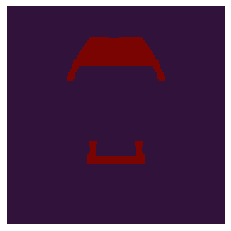

In [11]:
plt.imshow(target[64], cmap='turbo', interpolation='none')
plt.axis('off')

We do not need the target surface anymore, so we move it far away from the vial so it doesn't affect performance when rendering:

In [12]:
params['target.vertex_positions'] += 1e5
params.update();

### Objective function

Objective functions are implemented as `Loss` sub-classes. We will use the thresholded loss function introduced by Wechsler et al [[2024]][1]. Parameters are provided as a dictionary, specifying the lower (`tl`) and upper (`tu`) thresholds.

[1]: https://opg.optica.org/oe/fulltext.cfm?uri=oe-32-8-14705&id=548744

In [13]:
from drtvam.loss import ThresholdedLoss
loss_fn = ThresholdedLoss({'tl': 0.9, 'tu': 0.95})

### Optimizer
We now need to define the parameters to optimize, and provide them to an *optimizer*, which will update them at each optimization step.

All elements in the list above can be modified, and the changes are propagated to the scene via `params.update()`. The parameter we are interested in optimizing is `projector.active_data`, which contains the values of all the active projector pixels, currently initialized at 0.

We will use the `LinearLBGFS` optimizer, which implements the L-BFGS update rule, with a performance optimization based on the consideration that the pattern projection is linear with respects to the patterns. To use it, we need to provide two functions: one to evaluate the objective function, and one to evaluate the gradient.

In [14]:
def eval_vol(vars):
    params[patterns_key] = vars[patterns_key]
    params.update()
    vol = mi.render(scene, params, integrator=integrator, spp=spp, spp_grad=spp_grad, seed=it)
    return vol

def eval_loss(y):
    return loss_fn(y, target)

We can now initialize the optimizer with these functions:

In [15]:
from drtvam.lbfgs import LinearLBFGS
opt = LinearLBFGS(render_fn=eval_vol, loss_fn=eval_loss)

Finally, we need to provide it with the parameters to optimize:

In [16]:
patterns_key = 'projector.active_data'
opt[patterns_key] = params[patterns_key]

## 3. Running the optimization

We are now ready to run the optimization. At each iteration, we will project the patterns, compute the loss and call `dr.backward` to backpropagate it to obtain the parameter gradients. The parameters are then updated by the optimizer, and we finally clip potential negative values to 0. We will do that for 40 iterations.

Projecting the patterns is done again with `mi.render`, with the same arguments. Note that we can provide both `spp` and `spp_grad`, which define the sample count for the evaluatin of the forward model and the backpropagation, respectively.

In [17]:
spp = 8
spp_grad = 16

for it in trange(40):
    # Update scene
    params.update(opt)
    # Simulate projections
    vol = mi.render(scene, params, integrator=integrator, spp=spp, spp_grad=spp_grad, seed=it)
    # Evaluate objective function
    loss = loss_fn(vol, target)
    # Backpropagate
    dr.backward(loss)
    # Update patterns
    opt.step(vol, loss)
    # Clip negative values
    opt[patterns_key] = dr.maximum(dr.detach(opt[patterns_key]), 0.)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.41it/s]


## 4. Visualizing the results

We can now evaluate the optimized results. We can start by rendering the final state of the optimization:

In [18]:
params.update(opt)
vol_final = mi.render(scene, params, integrator=integrator, spp=64, seed=0)

We can now look at the result slice by slice, and compare it with the target:

(-0.5, 127.5, 127.5, -0.5)

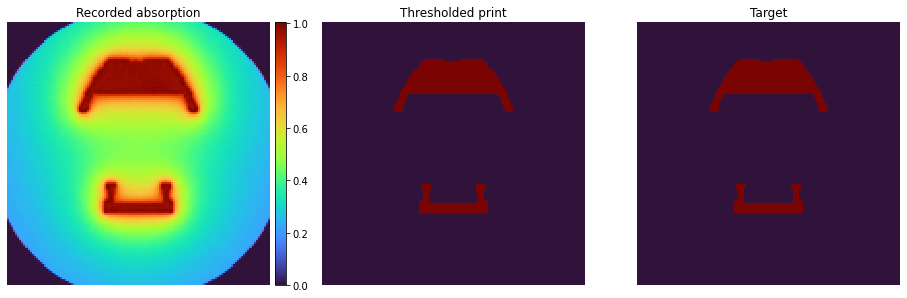

In [19]:
layer = 64
fig = plt.figure(1, figsize=(16, 5))
gs = fig.add_gridspec(1, 3, wspace=0.2)

ax = fig.add_subplot(gs[0])
im = ax.imshow(vol_final[layer], interpolation='none', cmap='turbo')
ax.set_title("Recorded absorption")
cbax = ax.inset_axes([1.02, 0, 0.04, 1], transform=ax.transAxes)
fig.colorbar(im, cax=cbax)
ax.axis('off')

ax = fig.add_subplot(gs[1])
ax.imshow(vol_final[layer] > 0.9, interpolation='none', cmap='turbo')
ax.set_title("Thresholded print")
ax.axis('off')

ax = fig.add_subplot(gs[2])
ax.imshow(target[layer], interpolation='none', cmap='turbo')
ax.set_title("Target")
ax.axis('off')

Another useful metric is to look at the *histogram* of recorded absorption. Ideally, we can observe good separation between object and non-object voxels, which indicates that polymerizing only the object part of the volume is feasible.

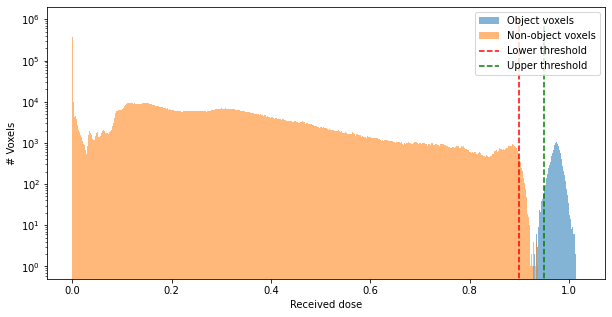

In [20]:
fig = plt.figure(figsize=(10, 5))
obj_mask = target.numpy().flatten() > 0.

voxels_final = vol_final.numpy().flatten()
bins = np.linspace(0, 1, 500)
plt.hist(voxels_final[obj_mask], bins=500, label="Object voxels", alpha=0.55)
plt.hist(voxels_final[~obj_mask], bins=500, label="Non-object voxels", alpha=0.55)
plt.vlines(0.9, 0, 1e6, linestyle='--', color='red', label='Lower threshold')
plt.vlines(0.95, 0, 1e6, linestyle='--', color='green', label='Upper threshold')

plt.yscale('log')
plt.ylabel("# Voxels")
plt.xlabel("Received dose")
plt.legend()

Finally, we can extract the projector patterns and visualize them:

In [21]:
patterns = scene.emitters()[0].patterns()

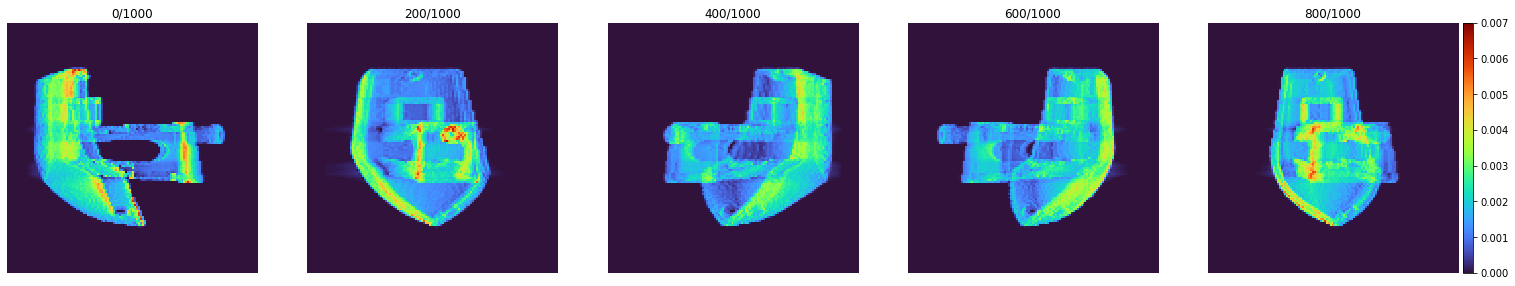

In [22]:
fig = plt.figure(1, figsize=(26, 5))
gs = fig.add_gridspec(1, 5, wspace=0.2)
pattern_count = patterns.shape[0]

for i in range(5):
    pattern_id = i * pattern_count // 5
    ax = fig.add_subplot(gs[i])
    im = ax.imshow(patterns[pattern_id], vmax=7e-3, interpolation='none', cmap='turbo')
    ax.set_title(f"{pattern_id}/{pattern_count}")
    ax.axis('off')

cbax = ax.inset_axes([1.02, 0, 0.04, 1], transform=ax.transAxes)
fig.colorbar(im, cax=cbax)